<a href="https://colab.research.google.com/github/LuciaManzanoUOC/MTP-UOC/blob/main/GeneralModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# General Model for detection of skin cancer in phototypes IV, V and VI

Student: Manzano Gómez, Lucía Reyes

Supervisor: Rebrij, Romina Astrid

Date last modification: May 15th, 2022

## CNN Transfer Learning

In this notebook we will develop a Convolutional Neural Network (CNN) to detect skin cancer on images of moles. 

We use a dataset of 1,000 images of benign moles and 1,000 images of malignant melanomas obtained in The International Skin Imaging Collaboration website [`ISIC archive`](https://www.isic-archive.com/) and modified to have darker skin phototypes. It has been divided between three datasets:

*   Train (70%)
*   Validation (15%)
*   Test (15%)

Images used in this file have phototypes IV, V or VI.

In [ ]:
# Import of libraries and use of GPUs to accelerate the training of the model.
%tensorflow_version 2.x
import tensorflow as tf
# Check if the GPUs are active
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print('GPU device not found')
else:
  print('Found GPU at: {}'.format(device_name))

# Rest of libraries needed.
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from posixpath import join
import os
from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras.callbacks import EarlyStopping
from sklearn import metrics
from keras.applications.imagenet_utils import decode_predictions
import random

Found GPU at: /device:GPU:0


In [ ]:
# Mount our Google Drive where the database of images is stored.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Once we are connected to Google Drive, unzip the database to obtain the
# images. These have already been divided among train (70%), test (15%) and 
# validation (15%).
!unzip drive/MyDrive/TFM/Databases/Database_All.zip

Archive:  drive/MyDrive/TFM/Databases/Database_All.zip
replace Database_All/test/Benign/ISIC_4265714.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: Database_All/test/Benign/ISIC_4265714.jpeg  
  inflating: Database_All/test/Benign/ISIC_4265726.jpeg  
  inflating: Database_All/test/Benign/ISIC_4265755.jpeg  
  inflating: Database_All/test/Benign/ISIC_4266157.jpeg  
  inflating: Database_All/test/Benign/ISIC_4266246.jpeg  
  inflating: Database_All/test/Benign/ISIC_4266501.jpeg  
  inflating: Database_All/test/Benign/ISIC_4266570.jpeg  
  inflating: Database_All/test/Benign/ISIC_4266571.jpeg  
  inflating: Database_All/test/Benign/ISIC_4267177.jpeg  
  inflating: Database_All/test/Benign/ISIC_4267696.jpeg  
  inflating: Database_All/test/Benign/ISIC_4267719.jpeg  
  inflating: Database_All/test/Benign/ISIC_4268757.jpeg  
  inflating: Database_All/test/Benign/ISIC_4269227.jpeg  
  inflating: Database_All/test/Benign/ISIC_4270126.jpeg  
  inflating: Database_All/test/Benign/ISI

In [ ]:
# Set the number of images in each dataset.
n_benign = 1000
n_malignant = 1000
n_total = n_benign + n_malignant

# Define the percentage of data in each dataset.
n_train = n_total * 70 / 100
n_val = n_total * 15 / 100
n_test = n_total * 15 / 100

# Display information.
print("The number of images in the train dataset is: ", n_train)
print("The number of images in the validation dataset is: ", n_val)
print("The number of images in the test dataset is: ", n_test)

The number of images in the train dataset is:  1400.0
The number of images in the validation dataset is:  300.0
The number of images in the test dataset is:  300.0


In [ ]:
# We start preparing the data before working on the model.
# Definition of batch size.
BATCH_SIZE = 16
# Definition of images size.
IMG_SIZE = (224, 224)

# Build the train dataset.
train_dataset = image_dataset_from_directory("Database_All/train",
                                             shuffle=False,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 2800 files belonging to 2 classes.


In [ ]:
# Build the test dataset.
test_dataset = image_dataset_from_directory("Database_All/test",
                                             shuffle=False,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 600 files belonging to 2 classes.


In [ ]:
# Build the validation dataset.
val_dataset = image_dataset_from_directory("Database_All/validation",
                                             shuffle=False,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 600 files belonging to 2 classes.


Examples of benign moles:



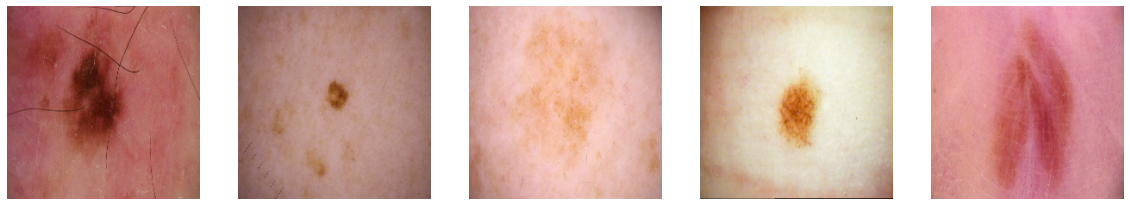

In [ ]:
# Show the first five images of benign moles.
class_names = train_dataset.class_names

plt.figure(figsize=(20, 20))
for images, labels in train_dataset.take(1):
  i = 0
  j = 0
  print("Examples of benign moles:\n")
  while i < 5:
    if(class_names[labels[j]] == "Benign"): 
      ax = plt.subplot(1, 5, i + 1)
      plt.imshow(images[j].numpy().astype("uint8"))
      plt.axis("off")
      i += 1
    j += 1

In [ ]:
train_ds = train_dataset.unbatch()
images = list(train_ds.map(lambda x, y: x))
labels = list(train_ds.map(lambda x, y: y))

Examples of malignant melanomas:



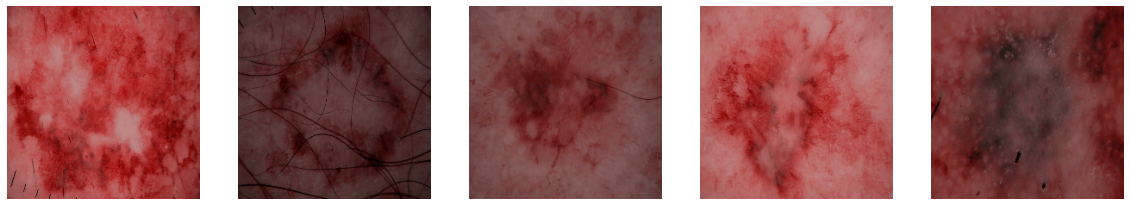

In [ ]:
train_ds = train_dataset.unbatch()
images = list(train_ds.map(lambda x, y: x))
labels = list(train_ds.map(lambda x, y: y))

# And the first five images of malignant melanomas.
plt.figure(figsize=(20, 20))
i = 0
j = 0
index = labels.index(1)
print("Examples of malignant melanomas:\n")
while i < 5:
  if(class_names[labels[index + i]] == "Malignant"): 
    ax = plt.subplot(1, 5, i + 1)
    plt.imshow(images[index + i].numpy().astype("uint8"))
    plt.axis("off")
  i += 1

In [ ]:
# Creation of the general model.
# Resize the images to have a new third dimension for the Convoutional Neuronal
# Network (CNN). The image shape then is (224, 224, 3)
IMG_SHAPE = IMG_SIZE + (3,)

# Create a first model based on the ResNet50 architecture with no precalculated
# weights
model_ResNet50 = tf.keras.applications.ResNet50(input_shape = IMG_SHAPE,
                                               include_top = False,
                                               pooling = 'avg',
                                               weights = None)

# Visualize the model created
print(model_ResNet50.summary())

In [ ]:
# Preparation of the data for the model.
preprocess_input = tf.keras.applications.resnet.preprocess_input
image_batch, label_batch = next(iter(train_dataset))
feature_batch = model_ResNet50(image_batch)
model_ResNet50.trainable = True

# The last layer only have one neuron as only two possible values are needed.
# Depending on the value obtained, the prediction is:
# If the value is a negative number, then the result is Benign .
# If the value is a positive number, then the result is Malignant. 
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch)
print(prediction_batch.shape)

(16, 1)


In [ ]:
# 
inputs = tf.keras.Input(shape = (224, 224, 3))
x = preprocess_input(inputs)
x = model_ResNet50(x, training = False)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1)                 2049      
                                                             

In [ ]:
# Compile the model
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00001),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits = True),
              metrics=['accuracy'])

# Usamos la técnica de Early Stopping para evitar el sobreentrenamiento
callbacks = EarlyStopping(monitor = 'val_accuracy', patience = 20)

# Train the model
history = model.fit(train_dataset,
                    epochs = 50,
                    validation_data = val_dataset,
                    callbacks = callbacks)

Epoch 1/50
175/175 [==============================] - 91s 486ms/step - loss: 0.9923 - accuracy: 0.9536 - val_loss: 18.8127 - val_accuracy: 0.5000
Epoch 2/50
175/175 [==============================] - 84s 481ms/step - loss: 1.4933 - accuracy: 0.8904 - val_loss: 6.4550 - val_accuracy: 0.5000
Epoch 3/50
175/175 [==============================] - 84s 481ms/step - loss: 0.5934 - accuracy: 0.8789 - val_loss: 5.5198 - val_accuracy: 0.5000
Epoch 4/50
175/175 [==============================] - 84s 480ms/step - loss: 0.6852 - accuracy: 0.8464 - val_loss: 4.1921 - val_accuracy: 0.5000
Epoch 5/50
175/175 [==============================] - 84s 480ms/step - loss: 0.6631 - accuracy: 0.8146 - val_loss: 3.8071 - val_accuracy: 0.5000
Epoch 6/50
175/175 [==============================] - 84s 479ms/step - loss: 0.6581 - accuracy: 0.7796 - val_loss: 2.9205 - val_accuracy: 0.5000
Epoch 7/50
175/175 [==============================] - 84s 477ms/step - loss: 0.6842 - accuracy: 0.7193 - val_loss: 2.1308 - val_a

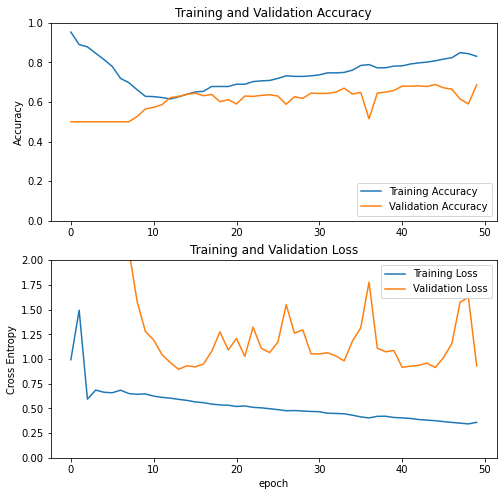

In [ ]:
# Plot the results for the train and validation dataset:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Accuracy
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label = 'Training Accuracy')
plt.plot(val_acc, label = 'Validation Accuracy')
plt.legend(loc ='lower right')
plt.ylabel('Accuracy')
plt.ylim([0, 1.0])
plt.title('Training and Validation Accuracy')

# Loss
plt.subplot(2, 1, 2)
plt.plot(loss, label = 'Training Loss')
plt.plot(val_loss, label = 'Validation Loss')
plt.legend(loc ='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, 2.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
# Save the model
model.save('general_model.h5')

In [ ]:
# Evaluate the model using the Test dataset.
loss_test, acc_test = model.evaluate(test_dataset, batch_size=BATCH_SIZE, 
                                     verbose=1)
print("Accuracy of the model for Test dataset: {:5.2f}%".format(100 * acc_test))
print("Loss of the model for Test dataset: {:5.2f}%".format(100 * loss_test))

38/38 [==============================] - 12s 303ms/step - loss: 0.9073 - accuracy: 0.7083
Accuracy of the model for Test dataset: 70.83%
Loss of the model for Test dataset: 90.73%


In [23]:
# Obtain the predictions of the Test.
predictions = model.predict(test_dataset, batch_size=BATCH_SIZE, 
                                     verbose=1) 
predictions_class = []
predictions_binary = []
for i in predictions:
  if i < 0:
    predictions_binary.append(0)
    predictions_class.append("Benign")
  else:
    predictions_binary.append(1)
    predictions_class.append("Malignant")

38/38 [==============================] - 18s 440ms/step


Examples of predictions of the Test dataset:



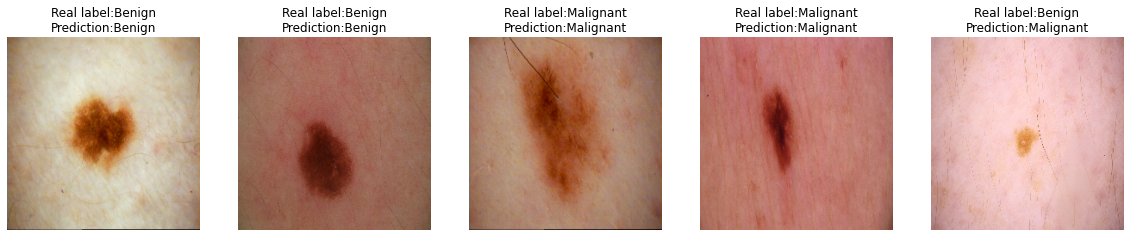

In [24]:
class_test = test_dataset.class_names

test_ds = test_dataset.unbatch()
images = list(test_ds.map(lambda x, y: x))
labels = list(test_ds.map(lambda x, y: y))

# Display some images of moles from the Test dataset, their diagnosis and the 
# prediction obtained.
plt.figure(figsize=(20, 20))

i = 0
print("Examples of predictions of the Test dataset:\n")
while i < 5:
  # Get five random numbers to select images in the test dataset
  rand_number = random.randrange(0, len(labels), 1)
  ax = plt.subplot(1, 5, i + 1)
  real_value = 'Real label:' + class_test[labels[rand_number]] + '\n'
  prediction_value = 'Prediction:' + predictions_class[rand_number]
  title = real_value + prediction_value
  plt.title(title)
  plt.imshow(images[i].numpy().astype("uint8"))
  plt.axis("off")
  i += 1

In [25]:
print('Confussion matrix for phototypes IV, V and VI:')
conf_matrix1 = metrics.confusion_matrix(labels, predictions_binary)
print(conf_matrix1)
print(' ')
print('True positives:', round(conf_matrix1[1,1]))
print('True negatives:', round(conf_matrix1[0,0]))
print('False positives:', round(conf_matrix1[1,0]))
print('False negatives:', round(conf_matrix1[0,1]))
print(' ')

# Display some statistics
print('Sensibility:', round(conf_matrix1[1,1]/(conf_matrix1[1,1]+conf_matrix1[1,0]),2))
print('Specificity:', round(conf_matrix1[0,0]/(conf_matrix1[0,0]+conf_matrix1[0,1]),2))
print('Positive predictive value (precision):', round(conf_matrix1[1,1]/(conf_matrix1[1,1]+conf_matrix1[0,1]),2))
print('Negative predictive value:', round(conf_matrix1[0,0]/(conf_matrix1[0,0]+conf_matrix1[1,0]),2))
print('Accuracy:', round((conf_matrix1[0,0]+conf_matrix1[1,1])/(conf_matrix1[0,0]+conf_matrix1[1,1]+
                                                         conf_matrix1[1,0]+conf_matrix1[0,1]),2))

Confussion matrix for phototypes IV, V and VI:
[[ 97 203]
 [  4 296]]
 
True positives: 296
True negatives: 97
False positives: 4
False negatives: 203
 
Sensibility: 0.99
Specificity: 0.32
Positive predictive value (precision): 0.59
Negative predictive value: 0.96
Accuracy: 0.66
